# Let's use a Data Loader now

In [1]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [ ]:
import torch
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

transformed_cifar10 = datasets.CIFAR10(
        data_path, train=True, download=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,
                std)
        ]))
transformed_cifar10_test = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10
    if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_test
    if label in [0, 2]]

In [ ]:
import torch
import torch.nn as nn

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

Now to the training loop:

In [ ]:
import torch.optim as optim

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.741002
Epoch: 1, Loss: 0.202902
Epoch: 2, Loss: 0.477165
Epoch: 3, Loss: 0.473894
Epoch: 4, Loss: 0.441943
Epoch: 5, Loss: 0.195325
Epoch: 6, Loss: 0.224233
Epoch: 7, Loss: 0.271204
Epoch: 8, Loss: 0.335036
Epoch: 9, Loss: 0.306430
Epoch: 10, Loss: 0.437555
Epoch: 11, Loss: 0.200985
Epoch: 12, Loss: 0.669533
Epoch: 13, Loss: 0.429679
Epoch: 14, Loss: 0.217611
Epoch: 15, Loss: 0.231916
Epoch: 16, Loss: 0.267550
Epoch: 17, Loss: 0.460777
Epoch: 18, Loss: 0.503644
Epoch: 19, Loss: 0.379193
Epoch: 20, Loss: 0.372461
Epoch: 21, Loss: 0.300076
Epoch: 22, Loss: 0.148997
Epoch: 23, Loss: 0.313084
Epoch: 24, Loss: 0.120945
Epoch: 25, Loss: 0.173020
Epoch: 26, Loss: 0.171603
Epoch: 27, Loss: 0.257246
Epoch: 28, Loss: 0.303625
Epoch: 29, Loss: 0.189082
Epoch: 30, Loss: 0.144216
Epoch: 31, Loss: 0.200064
Epoch: 32, Loss: 0.210155
Epoch: 33, Loss: 0.209165
Epoch: 34, Loss: 0.072467
Epoch: 35, Loss: 0.215702
Epoch: 36, Loss: 0.127607
Epoch: 37, Loss: 0.118915
Epoch: 38, Loss: 0.093

We notice that training in batches is not only faster but also it seems to give us a smaller loss to begin with.

Okay now let's thest the model

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
    print("Accuracy: ", str(correct / total * 100) + '%')

Accuracy:  82.05%


Let's see the accuracy on the training set as well:

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
    print("Training Accuracy: ", str(correct / total * 100) + '%')

Training Accuracy:  99.94%


The model probbly overfitted.

81.39% is a great accuracy but I belive we could do better, by improving the model.

We'll build a class this time 

In [ ]:
import torch.nn.functional as F
import datetime

class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1,8*8* self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [ ]:
def test_model(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total * 100
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)")

In [ ]:
modelDropout = NetDropout()

learning_rate = 1e-2
optimizer = optim.SGD(modelDropout.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100


training_loop_l2reg(n_epochs, optimizer, modelDropout, loss_fn, train_loader)

2025-06-15 22:40:00.487110 Epoch 1, Training loss 0.6012223190183092
2025-06-15 22:40:56.406221 Epoch 10, Training loss 0.4076748763679699
2025-06-15 22:41:57.353949 Epoch 20, Training loss 0.3830171353687906
2025-06-15 22:43:59.945942 Epoch 30, Training loss 0.357512073911679
2025-06-15 22:47:02.257253 Epoch 40, Training loss 0.3401077356497953
2025-06-15 22:50:02.026033 Epoch 50, Training loss 0.3314001347608627
2025-06-15 22:52:50.344908 Epoch 60, Training loss 0.31602984885121604
2025-06-15 22:55:49.156888 Epoch 70, Training loss 0.30747348108109396
2025-06-15 22:58:47.973373 Epoch 80, Training loss 0.2944838030702749
2025-06-15 23:01:54.181300 Epoch 90, Training loss 0.2908242531832616
2025-06-15 23:04:57.292980 Epoch 100, Training loss 0.2808274525176188


Now let's compute the Accuracies:

In [ ]:
test_model(modelDropout, train_loader, loss_fn)

Test Loss: 0.2067, Accuracy: 9192/10000 (91.92%)


In [ ]:
test_model(modelDropout, val_loader, loss_fn)

Test Loss: 0.2617, Accuracy: 1785/2000 (89.25%)


Let's visualise the differences between the models:

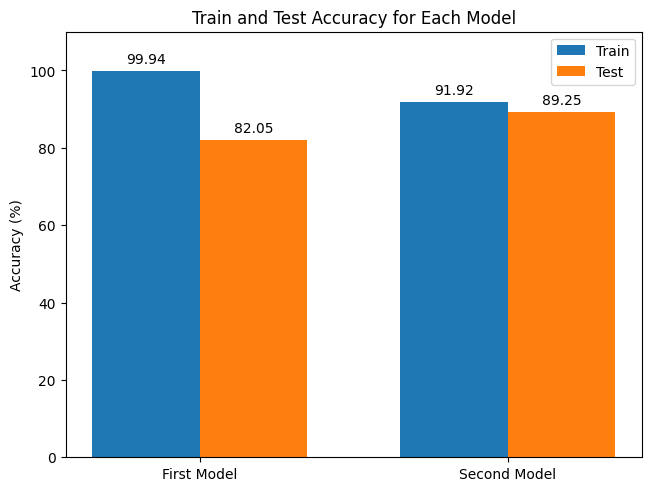

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

types = ['Train', 'Test']
firstModelAcc = [99.94, 82.05]
secondModelAcc = [91.92, 89.25]

x = np.array([0, 1])
width = 0.35

x_train = x - width / 2
x_test = x + width / 2

fig, ax = plt.subplots(layout='constrained')

train_bars = ax.bar(x_train[0], firstModelAcc[0], width, color='tab:blue', label='Train')
test_bars = ax.bar(x_test[0], firstModelAcc[1], width, color='tab:orange', label='Test')

train_bars2 = ax.bar(x_train[1], secondModelAcc[0], width, color='tab:blue')
test_bars2 = ax.bar(x_test[1], secondModelAcc[1], width, color='tab:orange')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Train and Test Accuracy for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(['First Model', 'Second Model'])
ax.set_ylim(0, 110)
ax.legend()

ax.bar_label(train_bars, padding=3, fmt='%.2f')
ax.bar_label(test_bars, padding=3, fmt='%.2f')
ax.bar_label(train_bars2, padding=3, fmt='%.2f')
ax.bar_label(test_bars2, padding=3, fmt='%.2f')
plt.show()